In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial import ConvexHull
import seaborn as sns

spdata = pd.read_pickle('SP.pkl')
mpdata = pd.read_pickle('MP.pkl')

### 1. 年龄与发病间隔时间

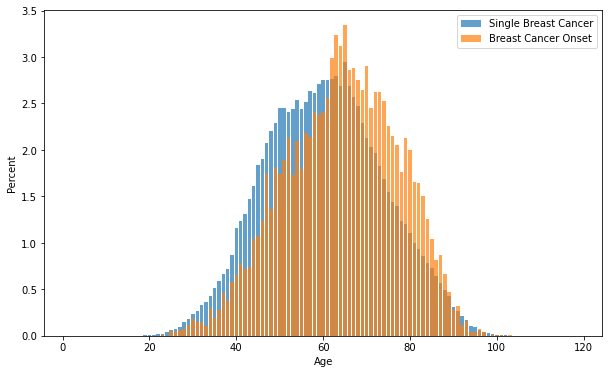

In [3]:
# 发病年龄散点图

sp_age = spdata.groupby('Age at diagnosis').size()/spdata.shape[0]*100
mp_age = mpdata[mpdata['Record number recode']==1].groupby('Age at diagnosis').size()/mpdata[mpdata['Record number recode']==1].shape[0]*100
op_age = mpdata[mpdata['Record number recode']==2].groupby('Age at diagnosis').size()/mpdata[mpdata['Record number recode']==2].shape[0]*100

plt.figure(figsize=(10, 6))
plt.bar(sp_age.index, sp_age.values, label='Single Breast Cancer', alpha=0.7);
plt.bar(mp_age.index, mp_age.values, label='Breast Cancer Onset', alpha=0.7);
# plt.bar(op_age.index, op_age.values, label='Other Cancer', alpha=0.4);
plt.xlabel('Age')
plt.ylabel('Percent')
plt.legend();
plt.show()

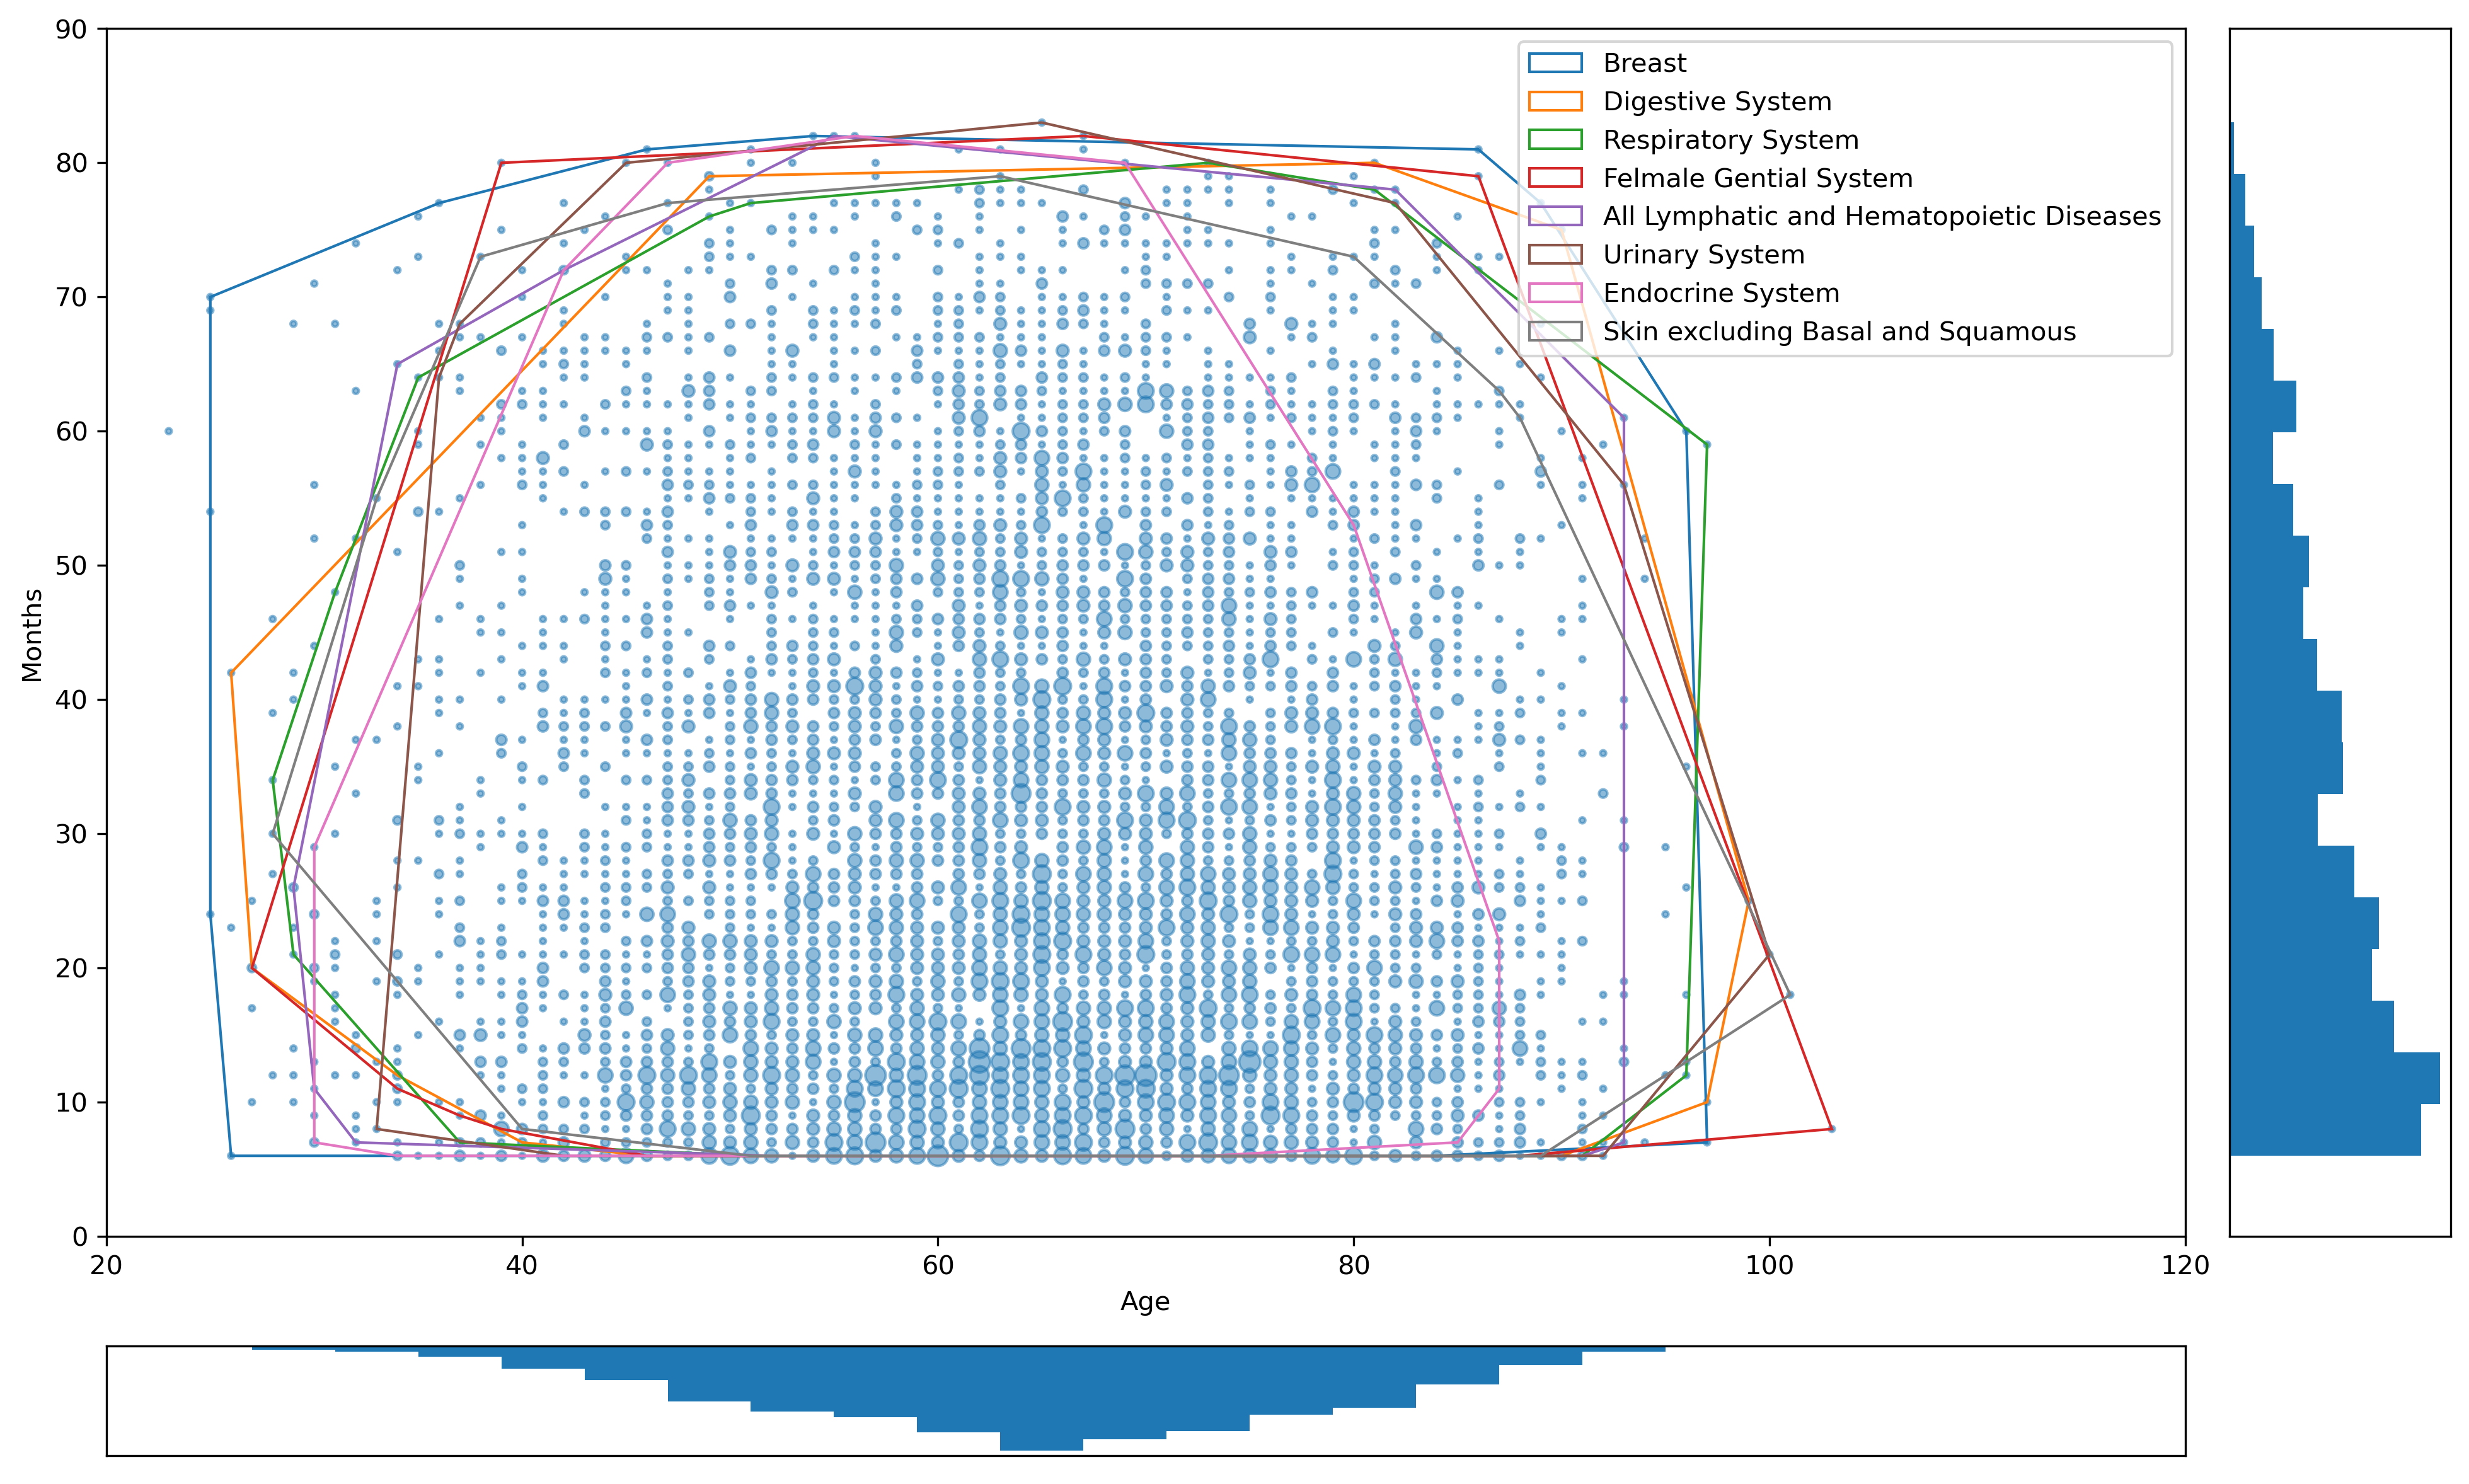

In [4]:
# 不同年龄患乳腺癌后继发其他癌的时间

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax_main.add_patch(poly)

timedata = pd.DataFrame()
timedata['Age at diagnosis'] = mpdata[mpdata['Record number recode']==1]['Age at diagnosis'].values
timedata['Months Since Index (Calculated)'] = mpdata[mpdata['Record number recode']==2]['Months Since Index (Calculated)'].values
timedata['Site recode'] = mpdata[mpdata['Record number recode']==2]['Site recode'].values

count = timedata.groupby(['Age at diagnosis','Months Since Index (Calculated)']).size()
top10cat = timedata.groupby('Site recode').size().sort_values(ascending=False).head(8)

# 设定子图位置
fig = plt.figure(figsize=(16,10), dpi=300)
grid = plt.GridSpec(7, 9, hspace=1, wspace=0.2)
ax_main = fig.add_subplot(grid[:-1,:-1])
ax_right = fig.add_subplot(grid[:-1,-1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1,:-1], xticklabels=[], yticklabels=[])

ax_main.set(xlabel='Age', ylabel='Months', xlim=(20,120), ylim=(0,90))
x = [ i[0] for i in count.index ]
y = [ i[1] for i in count.index ]
size = [ i*5 for i in count.values ]
ax_main.scatter(x, y, s=size, alpha=0.5)

for i, item in enumerate(top10cat.index):
    catframe = timedata[timedata['Site recode']==item]
    encircle(catframe['Age at diagnosis'],catframe['Months Since Index (Calculated)'], alpha=1, fc='none',ec=plt.cm.tab10(i), label=item)
ax_main.legend()

ax_bottom.set(xlim=(20,120), xticks=[], yticks=[])
ax_bottom.hist(timedata['Age at diagnosis'], bins=20, histtype='stepfilled', orientation='vertical')
ax_bottom.invert_yaxis()

ax_right.set(ylim=(0,90), xticks=[], yticks=[])
ax_right.hist(timedata['Months Since Index (Calculated)'], bins=20, histtype='stepfilled', orientation='horizontal',)

plt.show()

- 点的大小代表数量，前20种癌在50-80岁期间都可能出现，40岁以前有5种癌不会出现，1年内出现癌的几率较高

### 2. 不同类型与发病间隔时间

In [5]:
top10cat

Site recode
Breast                                      2269
Digestive System                            1525
Respiratory System                          1122
Felmale Gential System                       899
All Lymphatic and Hematopoietic Diseases     689
Urinary System                               484
Endocrine System                             481
Skin excluding Basal and Squamous            408
dtype: int64

In [6]:
141+105+74+61+24+6

411

In [7]:
411/8288

0.04958976833976834

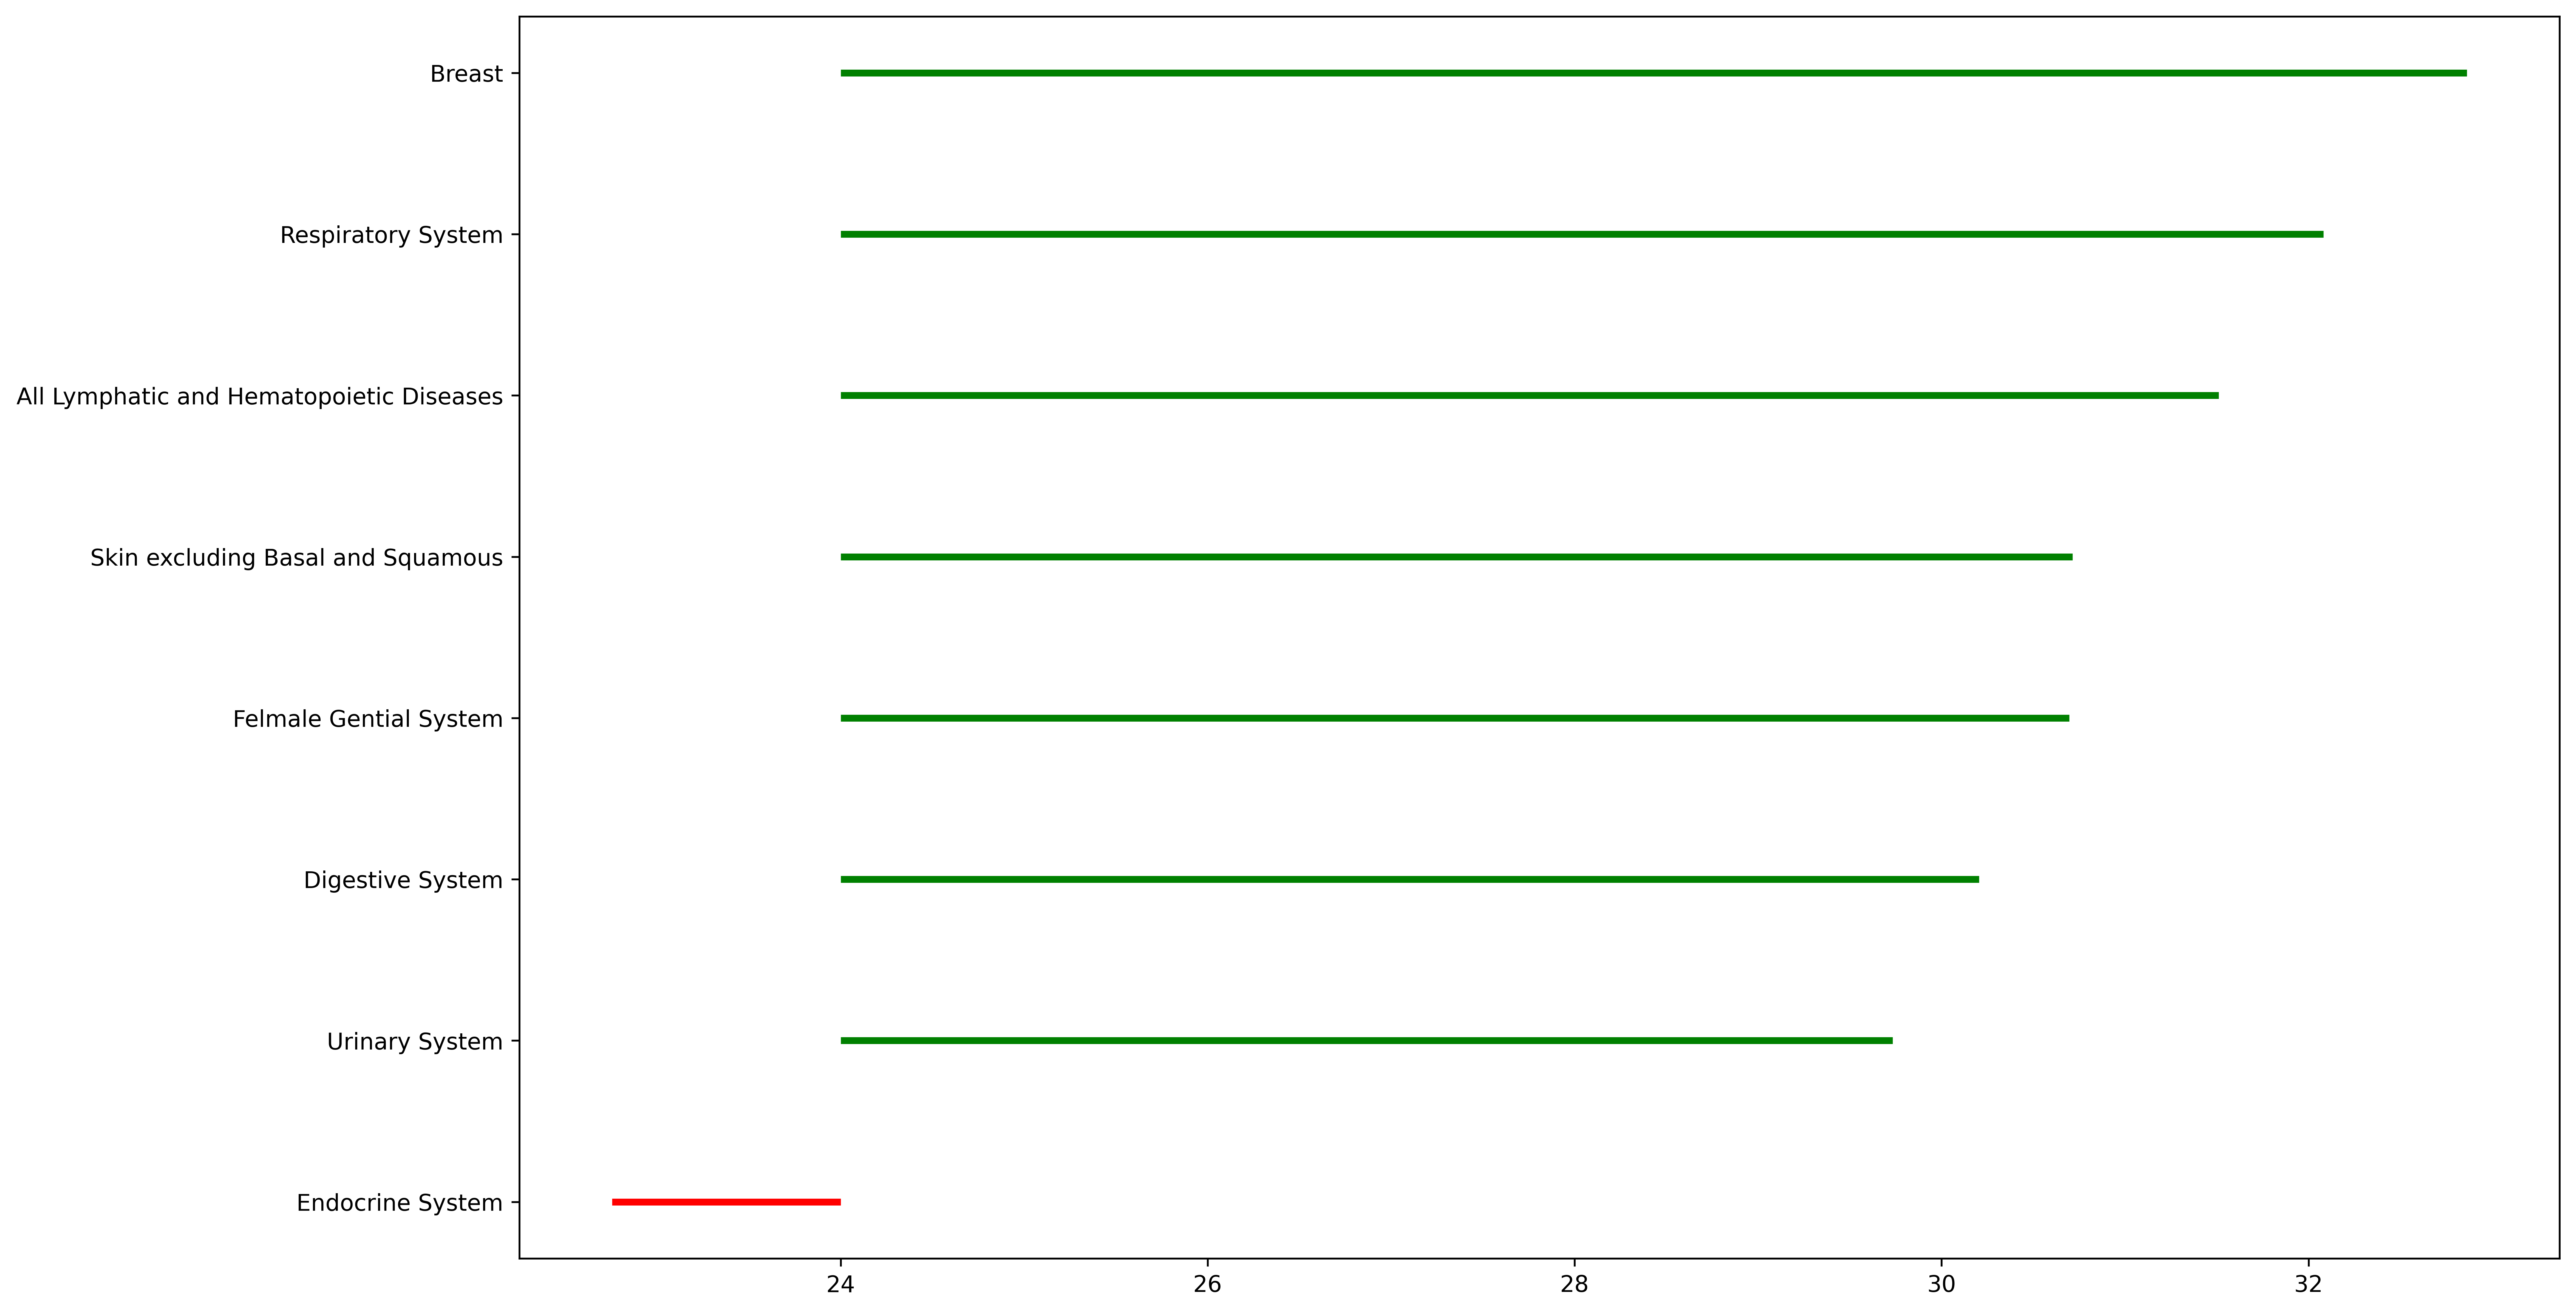

In [8]:
cancertypes = timedata.groupby('Site recode').size().sort_values(ascending=False).index[:8] # 这里设置需要多少种癌 前20改为index[:20]
cancer = pd.Series(dtype='float64')

for cancertype in cancertypes:
    cancer[cancertype] = timedata[timedata['Site recode']==cancertype]['Months Since Index (Calculated)'].mean()

cancer = cancer.sort_values()
plt.figure(figsize=(16,10), dpi=600)
plt.hlines(cancer.index, xmin=24, xmax=cancer.values, linewidth=3, color=['green' if i-24>0 else 'red' for i in cancer.values]);

In [9]:
subtype = pd.DataFrame()
subtype['type'] = mpdata[mpdata['Record number recode']==1]['Breast Subtype (2010+)'].values
subtype['site'] = mpdata[mpdata['Record number recode']==2]['Site recode'].values
subtype['time'] = mpdata[mpdata['Record number recode']==2]['Months Since Index (Calculated)'].values
subtype['time'] = subtype['time'].astype(float)

In [10]:
import joypy

<Figure size 9600x6000 with 0 Axes>

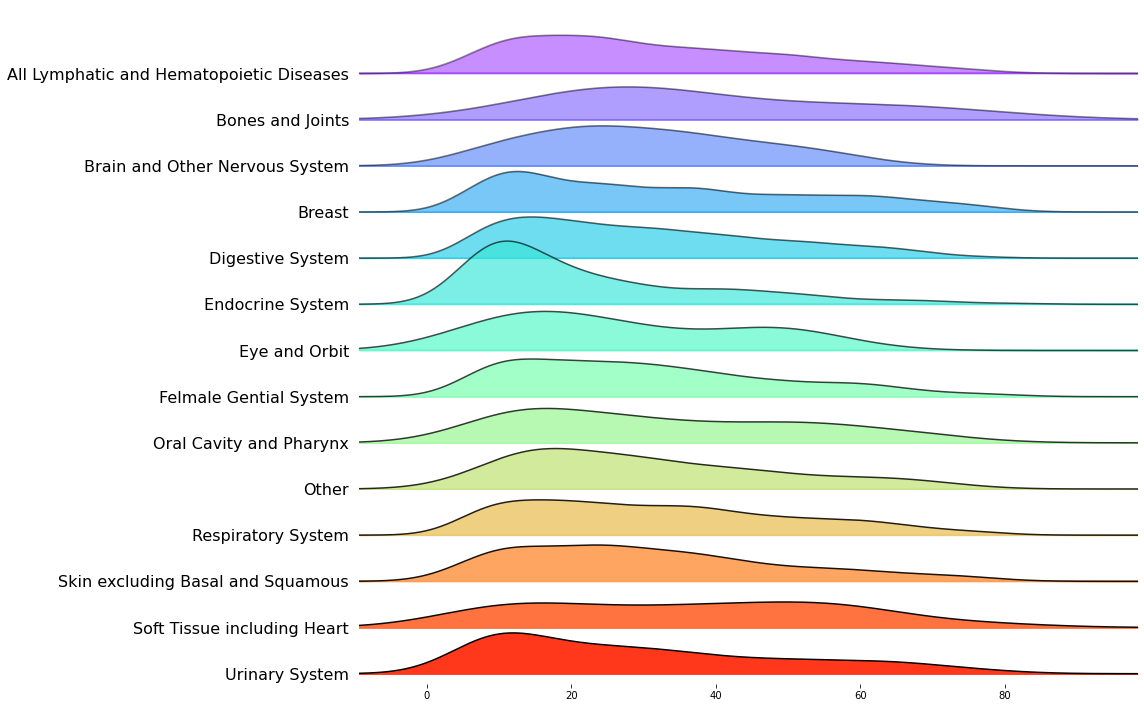

In [11]:
# 密度概率图 
plt.figure(figsize=(16,10), dpi=600);
joypy.joyplot(subtype, column='time', by='site', fade=True, overlap=0.7, colormap=plt.cm.rainbow, figsize=(16,10), ylabelsize=16);

In [12]:
# !pip install pywaffle

In [13]:
from pywaffle import Waffle

In [14]:
cat = timedata.groupby('Site recode').size().sort_values(ascending=False)
catdict = cat.to_dict()

In [15]:
catdict

{'Breast': 2269,
 'Digestive System': 1525,
 'Respiratory System': 1122,
 'Felmale Gential System': 899,
 'All Lymphatic and Hematopoietic Diseases': 689,
 'Urinary System': 484,
 'Endocrine System': 481,
 'Skin excluding Basal and Squamous': 408,
 'Other': 141,
 'Oral Cavity and Pharynx': 105,
 'Brain and Other Nervous System': 74,
 'Soft Tissue including Heart': 61,
 'Eye and Orbit': 24,
 'Bones and Joints': 6}

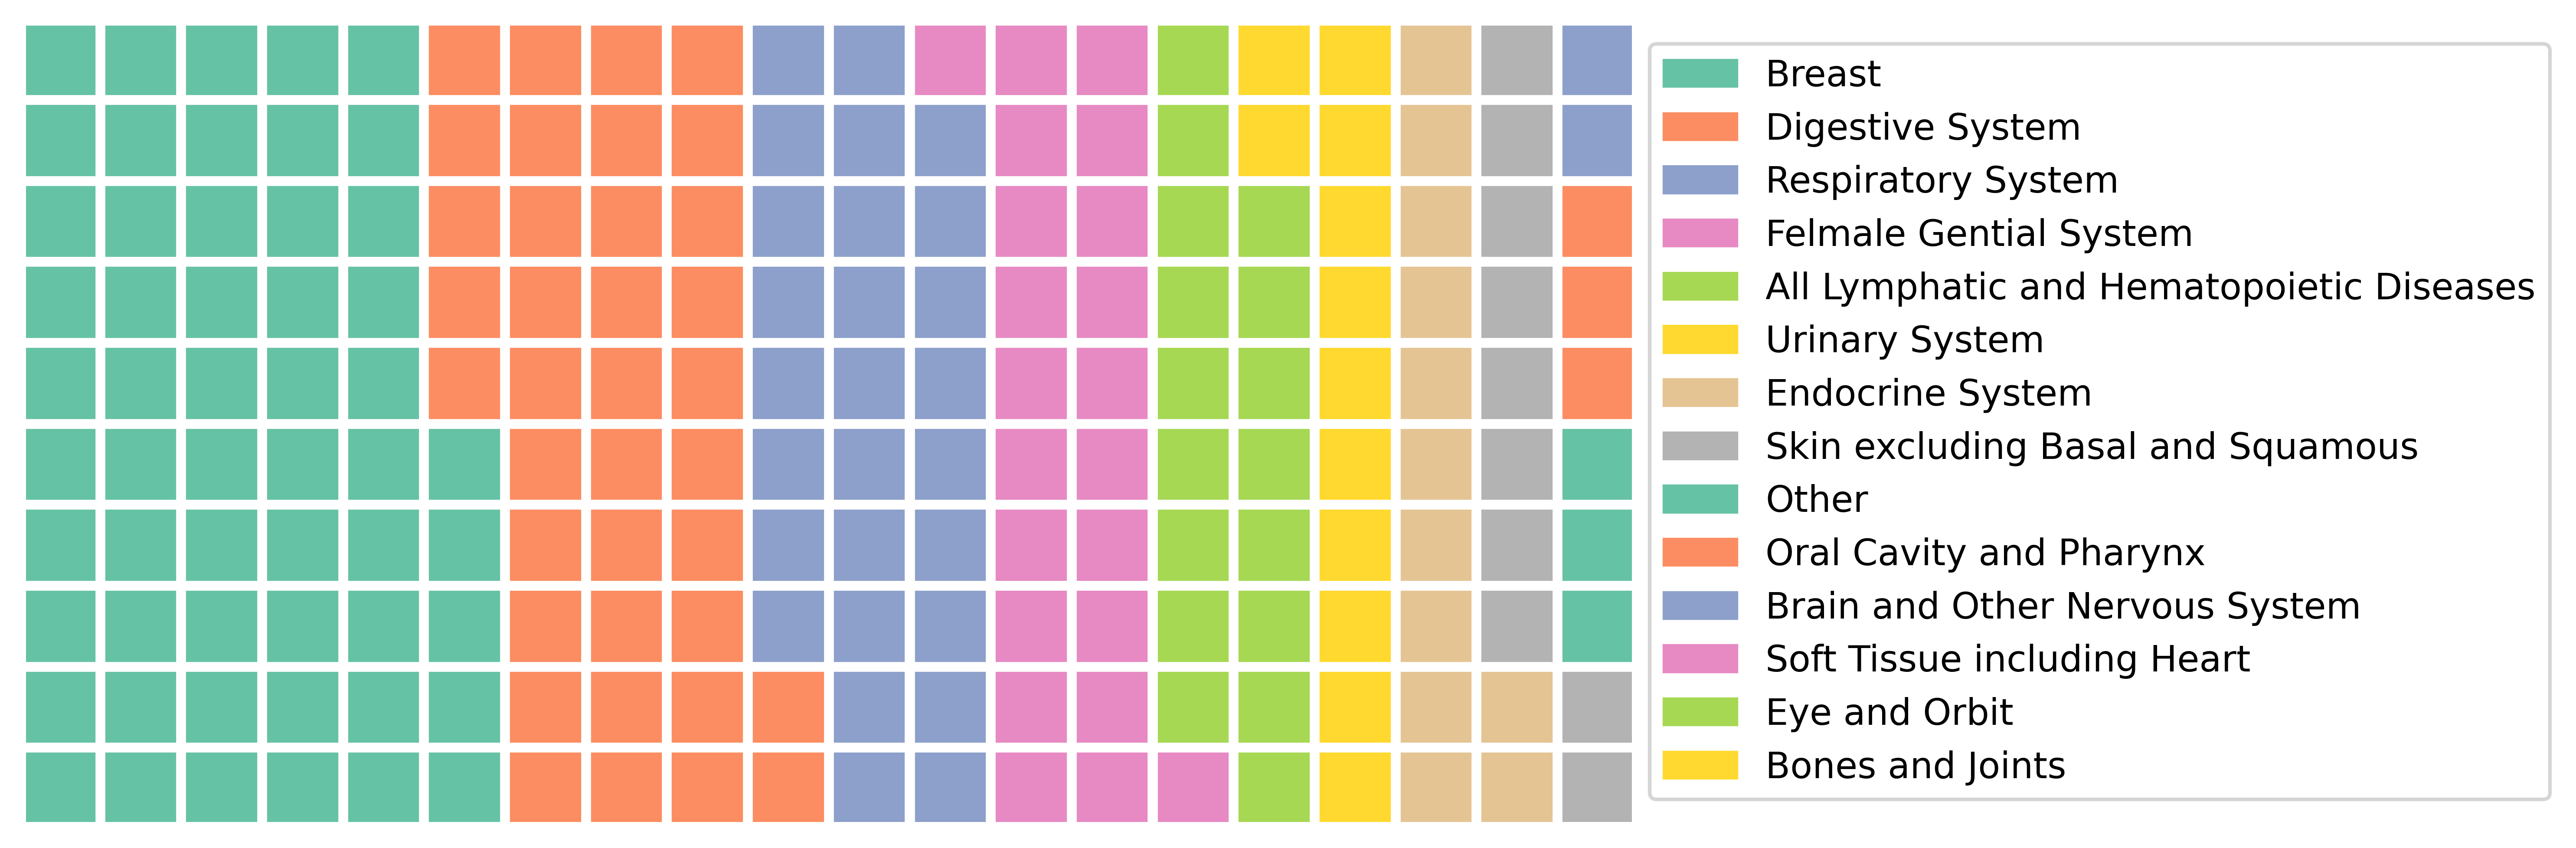

In [16]:
waf = plt.figure(
        figsize=(10,8),
        values=catdict,
        FigureClass=Waffle,
        rows=10,
        columns=20,
        colors=[],
        dpi=600,
        legend={
            'loc': 'upper left',
            'bbox_to_anchor': (1,1)
        }
)

### 3. 不同分子分型与第2原发癌类型

In [17]:
subtype

type                                      site  \
0           HR+/HER2- (Luminal A)         Skin excluding Basal and Squamous   
1           HR+/HER2- (Luminal A)                        Respiratory System   
2           HR+/HER2- (Luminal A)                                    Breast   
3           HR+/HER2- (Luminal A)                                    Breast   
4     HR-/HER2- (Triple Negative)                          Endocrine System   
...                           ...                                       ...   
8283        HR+/HER2- (Luminal A)                          Digestive System   
8284        HR+/HER2- (Luminal A)                                    Breast   
8285        HR+/HER2- (Luminal A)  All Lymphatic and Hematopoietic Diseases   
8286        HR+/HER2- (Luminal A)                          Digestive System   
8287        HR+/HER2- (Luminal A)                        Respiratory System   

      time  
0     16.0  
1     65.0  
2     55.0  
3     49.0  
4      6.0  
...    ...  
8283   9.0  
8284  16.0  
8285  22.0  
8286  11.0  
8287  20.0  

[8288 rows x 3 columns]

In [18]:
plt.figure(figsize=(26,20), dpi=600)
sns.histplot(data=subtype, x="site", hue="type", multiple="dodge", shrink=0.8)

<AxesSubplot:xlabel='site', ylabel='Count'>